In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-muted")  # minimal global style

df = pd.read_csv("health_armaan.csv", parse_dates=["date"]).sort_values("date").reset_index(drop=True)

num_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric cols:", len(num_df.columns))
num_df.head()

plt.style.use("seaborn-v0_8-muted") 



Numeric cols: 29


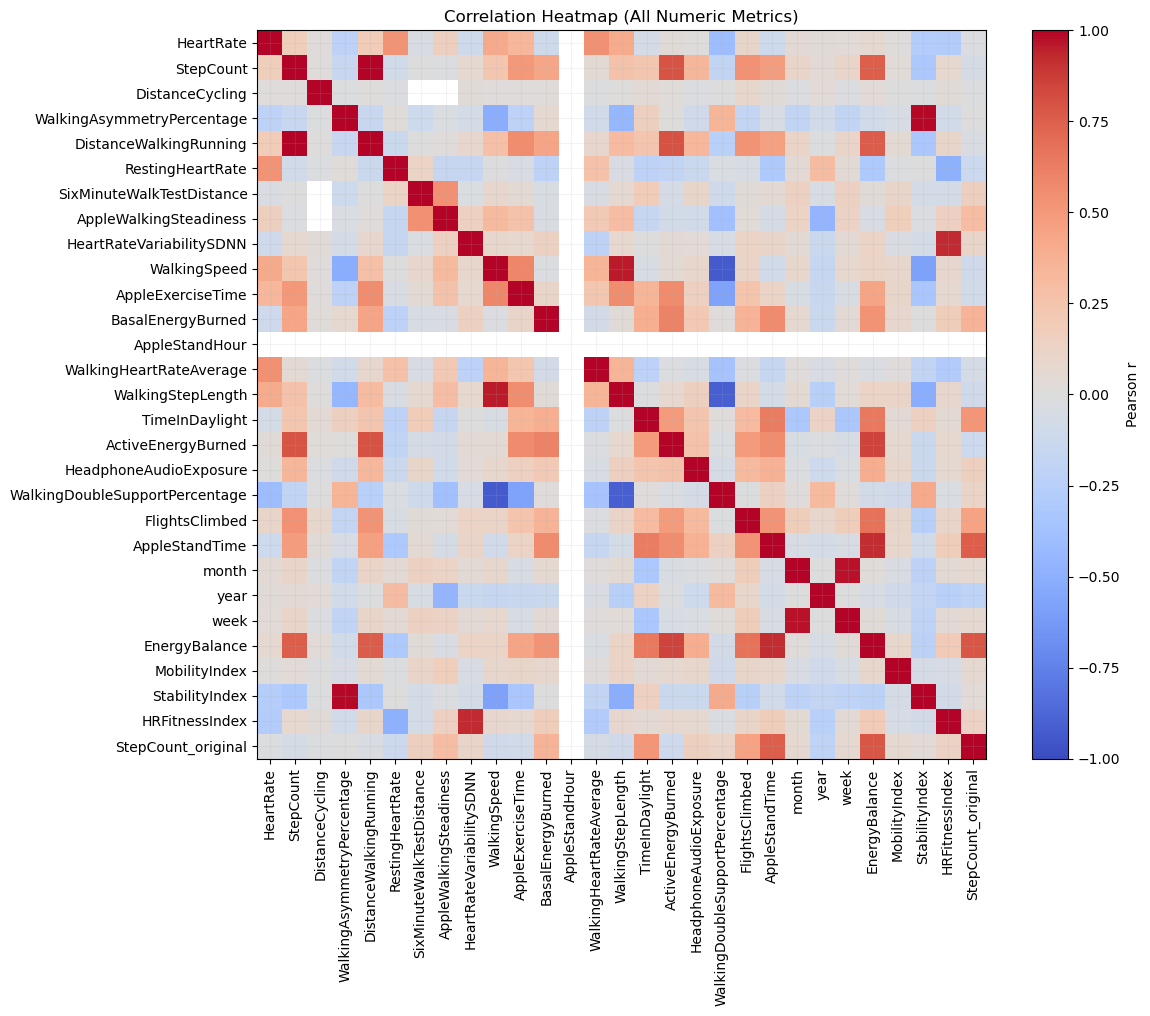

In [9]:
corr = num_df.corr()

plt.figure(figsize=(12,10))
im = plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (All Numeric Metrics)")
plt.colorbar(im, label="Pearson r")
plt.grid(alpha=0.15)
plt.tight_layout(); plt.show()


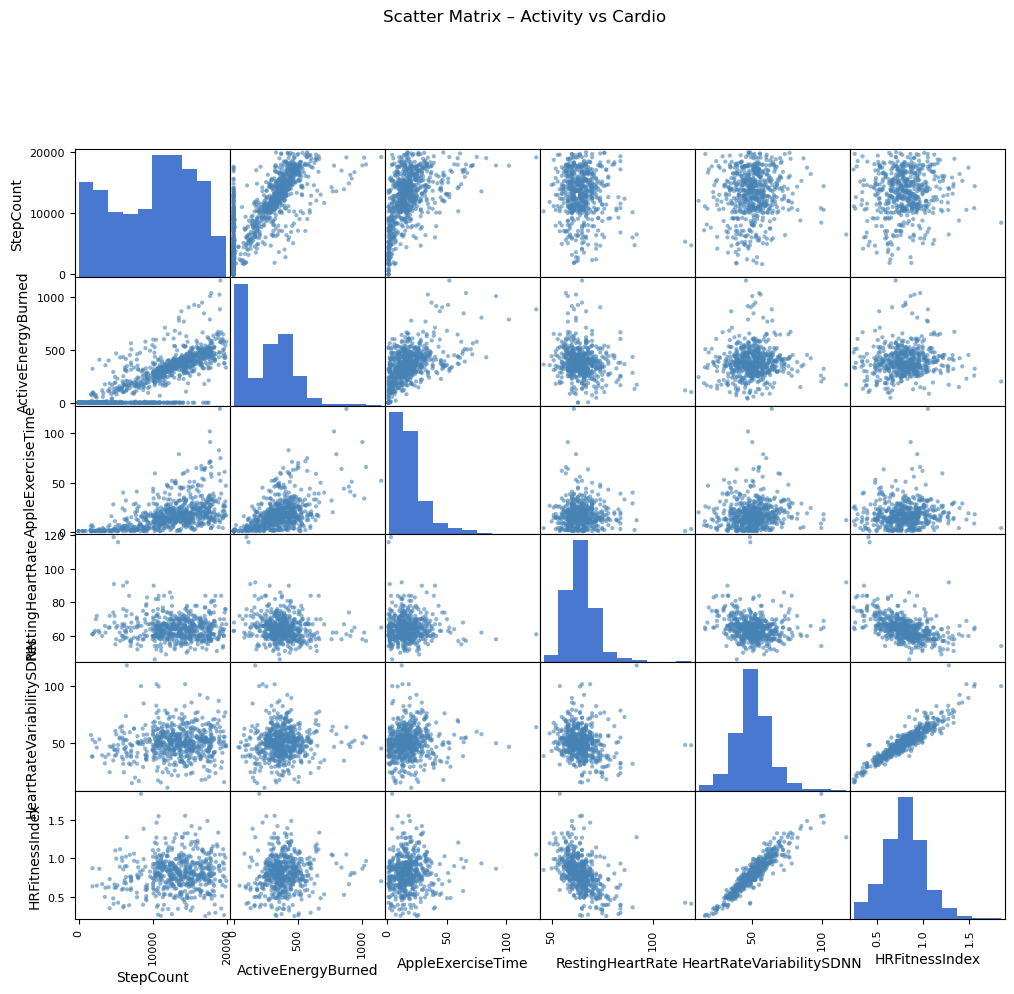

In [10]:
focus_cols = [
    "StepCount","ActiveEnergyBurned","AppleExerciseTime",
    "RestingHeartRate","HeartRateVariabilitySDNN","HRFitnessIndex"
]

pd.plotting.scatter_matrix(
    df[focus_cols],
    figsize=(12,10),
    diagonal="hist",
    color="steelblue",  # minimal color touch
    alpha=0.6
)
plt.suptitle("Scatter Matrix – Activity vs Cardio", y=1.02)
plt.show()


<Figure size 800x500 with 0 Axes>

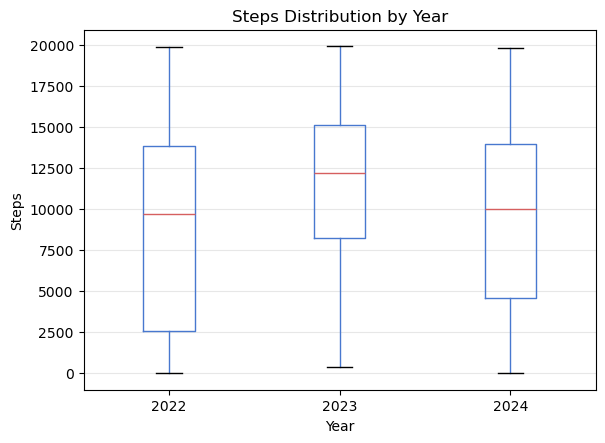

<Figure size 800x500 with 0 Axes>

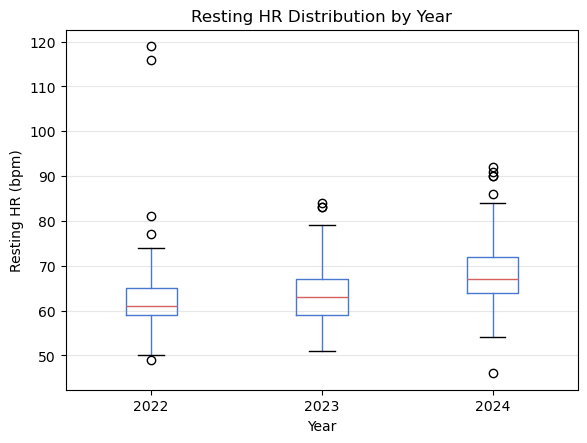

In [11]:
# Steps
plt.figure(figsize=(8,5))
df.boxplot(column="StepCount", by="year", grid=False)
plt.title("Steps Distribution by Year")
plt.suptitle("")
plt.xlabel("Year"); plt.ylabel("Steps")
plt.grid(alpha=0.3, axis="y")
plt.show()

# Resting HR
plt.figure(figsize=(8,5))
df.boxplot(column="RestingHeartRate", by="year", grid=False)
plt.title("Resting HR Distribution by Year")
plt.suptitle("")
plt.xlabel("Year"); plt.ylabel("Resting HR (bpm)")
plt.grid(alpha=0.3, axis="y")
plt.show()


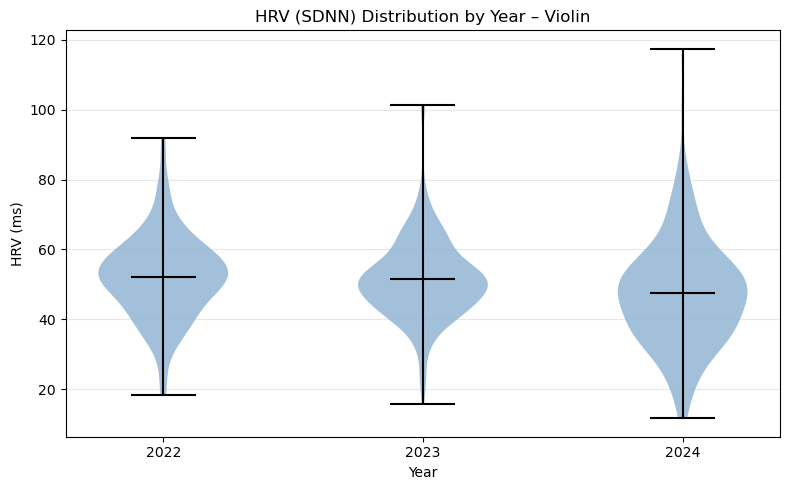

In [12]:
# Prepare HRV data grouped by year
years = sorted(df["year"].dropna().unique().tolist())
data_by_year = [df.loc[df["year"]==y, "HeartRateVariabilitySDNN"].dropna() for y in years]

fig, ax = plt.subplots(figsize=(8,5))
parts = ax.violinplot(data_by_year, showmeans=True, showextrema=True, showmedians=False)

# minimal color accents
for pc in parts['bodies']:
    pc.set_facecolor("steelblue")
    pc.set_alpha(0.5)
parts["cmeans"].set_color("black")
parts["cbars"].set_color("black")
parts["cmins"].set_color("black")
parts["cmaxes"].set_color("black")

ax.set_title("HRV (SDNN) Distribution by Year – Violin")
ax.set_xlabel("Year"); ax.set_ylabel("HRV (ms)")
ax.set_xticks(range(1, len(years)+1)); ax.set_xticklabels([str(y) for y in years])
ax.grid(alpha=0.3, axis="y")
plt.tight_layout(); plt.show()


In [14]:
coverage = 1 - num_df.isna().mean()
coverage.sort_values(ascending=False).to_frame("coverage").head()

feat_cols = coverage[coverage >= 0.70].index.tolist()

core_fallback = [
    "StepCount","ActiveEnergyBurned","AppleExerciseTime",
    "DistanceWalkingRunning","FlightsClimbed",
    "RestingHeartRate","HeartRateVariabilitySDNN",
    "WalkingSpeed","WalkingStepLength",
    "MobilityIndex","StabilityIndex","HRFitnessIndex",
    "year","month","week"
]
for c in core_fallback:
    if c in num_df.columns and c not in feat_cols:
        feat_cols.append(c)

# 3) Build feature matrix with median imputation
X_full = num_df[feat_cols].copy()
X_full = X_full.fillna(X_full.median(numeric_only=True))

print("Selected features:", len(feat_cols))
print(feat_cols[:12], "...")
print("Matrix shape:", X_full.shape)


Selected features: 20
['StepCount', 'DistanceCycling', 'WalkingAsymmetryPercentage', 'DistanceWalkingRunning', 'WalkingSpeed', 'BasalEnergyBurned', 'WalkingStepLength', 'ActiveEnergyBurned', 'WalkingDoubleSupportPercentage', 'FlightsClimbed', 'month', 'year'] ...
Matrix shape: (1096, 20)


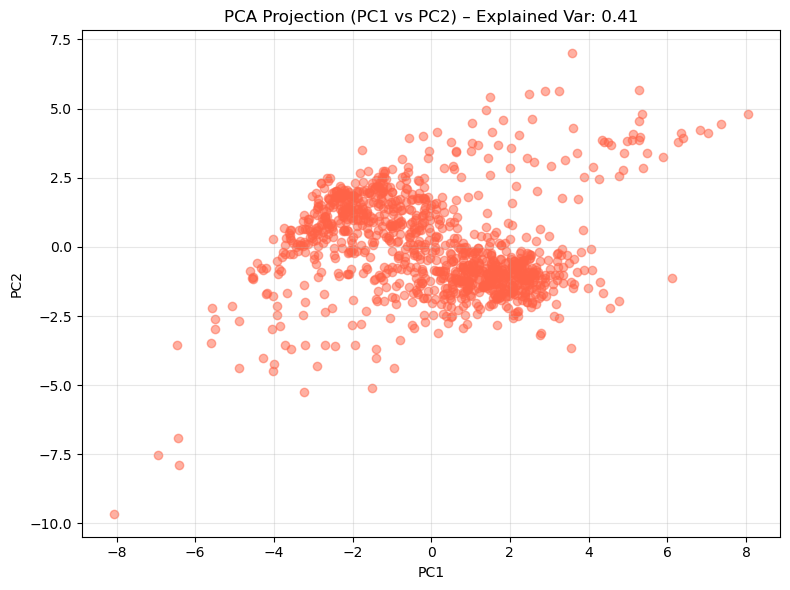

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-muted")

scaler = StandardScaler()
scaled = scaler.fit_transform(X_full)

pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(scaled)
expl = pca.explained_variance_ratio_.sum()

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], alpha=0.5, color="tomato")
plt.title(f"PCA Projection (PC1 vs PC2) – Explained Var: {expl:.2f}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [16]:
from sklearn.cluster import KMeans

cluster_cols = [c for c in [
    "StepCount","ActiveEnergyBurned","AppleExerciseTime",
    "DistanceWalkingRunning","FlightsClimbed",
    "RestingHeartRate","HeartRateVariabilitySDNN",
    "WalkingSpeed","WalkingStepLength"
] if c in X_full.columns]

Xc = X_full[cluster_cols].copy()

km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = km.fit_predict(Xc)

print("Cluster features:", cluster_cols)
print("Cluster sizes:", pd.Series(labels).value_counts().sort_index().to_dict())


Cluster features: ['StepCount', 'ActiveEnergyBurned', 'AppleExerciseTime', 'DistanceWalkingRunning', 'FlightsClimbed', 'RestingHeartRate', 'HeartRateVariabilitySDNN', 'WalkingSpeed', 'WalkingStepLength']
Cluster sizes: {0: 341, 1: 397, 2: 358}


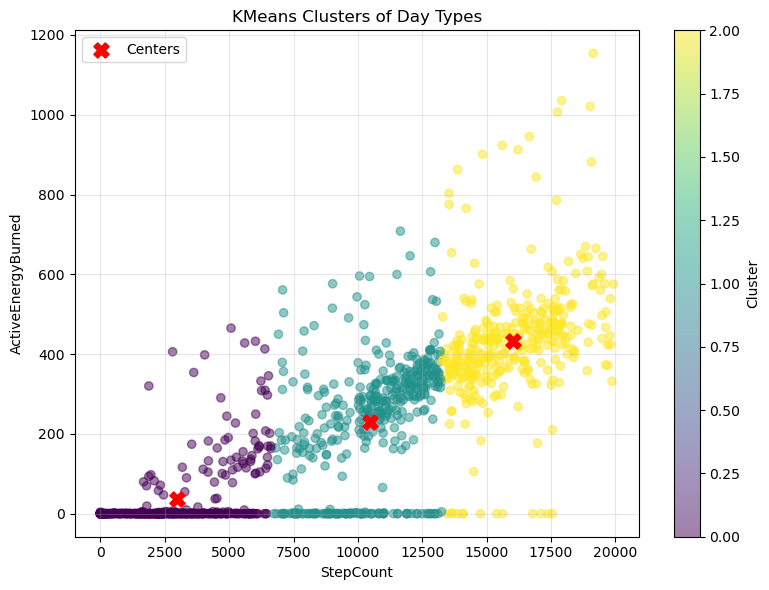

,StepCount,ActiveEnergyBurned,AppleExerciseTime,DistanceWalkingRunning,FlightsClimbed,RestingHeartRate,HeartRateVariabilitySDNN,WalkingSpeed,WalkingStepLength
0,2961.82,36.96,11.99,2.27,1.98,64.62,50.18,3.82,66.50
1,10484.29,229.38,14.96,8.11,12.12,64.27,50.56,4.04,69.22
2,16013.65,432.42,23.75,12.46,15.82,64.25,50.89,4.09,69.76


In [18]:
xcol = "StepCount"
ycol = "ActiveEnergyBurned"

plt.figure(figsize=(8,6))
sc = plt.scatter(Xc[xcol], Xc[ycol], c=labels, cmap="viridis", alpha=0.5)
plt.title("KMeans Clusters of Day Types")
plt.xlabel(xcol); plt.ylabel(ycol)
plt.grid(alpha=0.3)
cbar = plt.colorbar(sc, label="Cluster")

centers = pd.DataFrame(km.cluster_centers_, columns=Xc.columns)
plt.scatter(centers[xcol], centers[ycol], color="red", s=120, marker="X", label="Centers")
plt.legend()
plt.tight_layout(); plt.show()

centers.round(2)


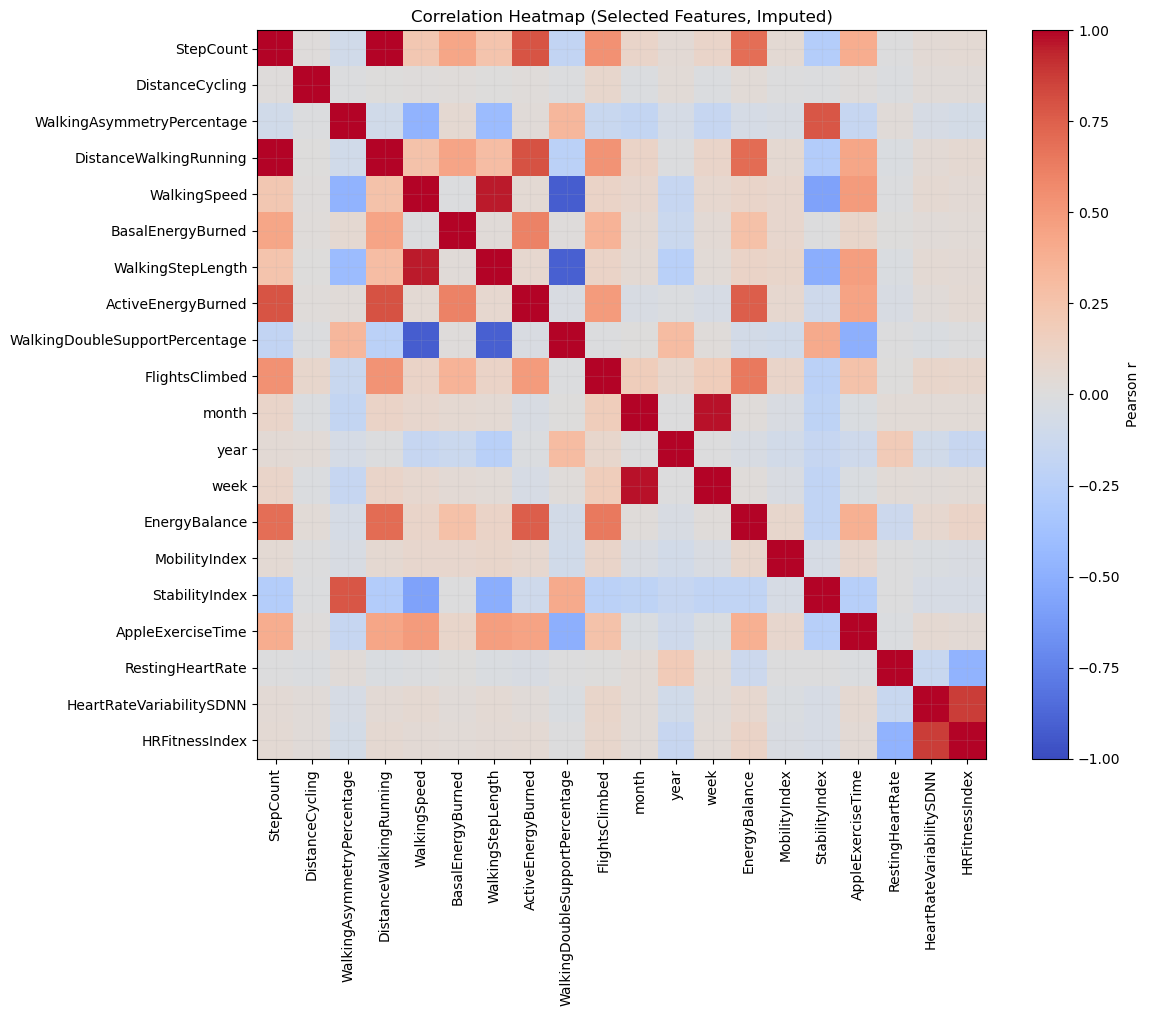

In [19]:
corr_sel = X_full.corr()

plt.figure(figsize=(12,10))
im = plt.imshow(corr_sel, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(range(len(corr_sel.columns)), corr_sel.columns, rotation=90)
plt.yticks(range(len(corr_sel.index)), corr_sel.index)
plt.title("Correlation Heatmap (Selected Features, Imputed)")
plt.colorbar(im, label="Pearson r")
plt.grid(alpha=0.15)
plt.tight_layout(); plt.show()
